In [22]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(
    host='localhost',
    user='Nandhu',
    password='245250',
    database='ecommerce'
)
cur =db.cursor()


#list all unique cities  where customer are  location 

In [6]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#Count the number of orders placed in 2018.

In [8]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2018 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2018 are", data[0][0]

('total orders placed in 2018 are', 216044)

In [10]:
#Find the total sales per category.

In [11]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,1520215.98
1,FURNITURE DECORATION,4290529.18
2,TELEPHONY,1460646.15
3,BED TABLE BATH,5137661.01
4,AUTOMOTIVE,2556882.99
...,...,...
69,CDS MUSIC DVDS,3598.29
70,LA CUISINE,8740.59
71,FASHION CHILDREN'S CLOTHING,2357.01
72,PC GAMER,6523.29


In [ ]:
#Calculate the percentage of orders that were paid in installments.

In [12]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

In [14]:
#Count the number of customers from each state.

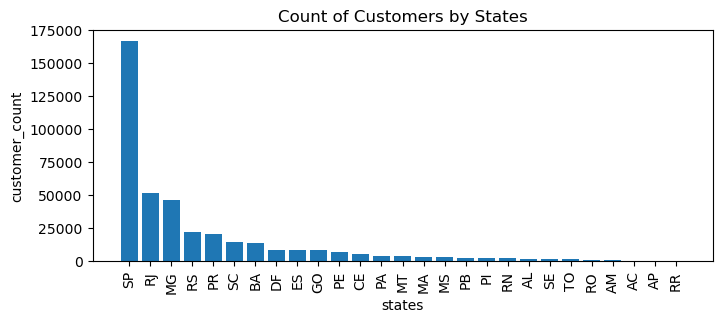

In [15]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

In [16]:
#Calculate the number of orders per month in 2018.

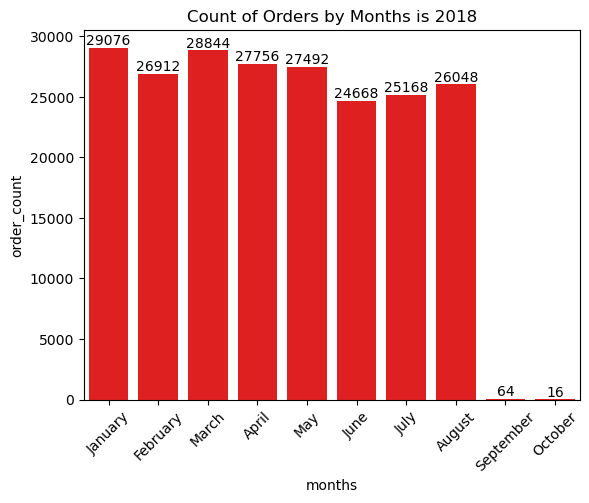

In [17]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

In [ ]:
#Find the average number of products per order, grouped by customer city.

In [18]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,curralinho,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,teixeira soares,16.00


In [ ]:
#Calculate the percentage of total revenue contributed by each product category.

In [19]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,32.09
1,HEALTH BEAUTY,31.06
2,COMPUTER ACCESSORIES,29.71
3,FURNITURE DECORATION,26.80
4,WATCHES PRESENT,26.78


In [ ]:
#Identify the correlation between product price and the number of times a product has been purchased.

In [23]:
cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157569


In [ ]:
#Calculate the total revenue generated by each seller, and rank them by revenue.

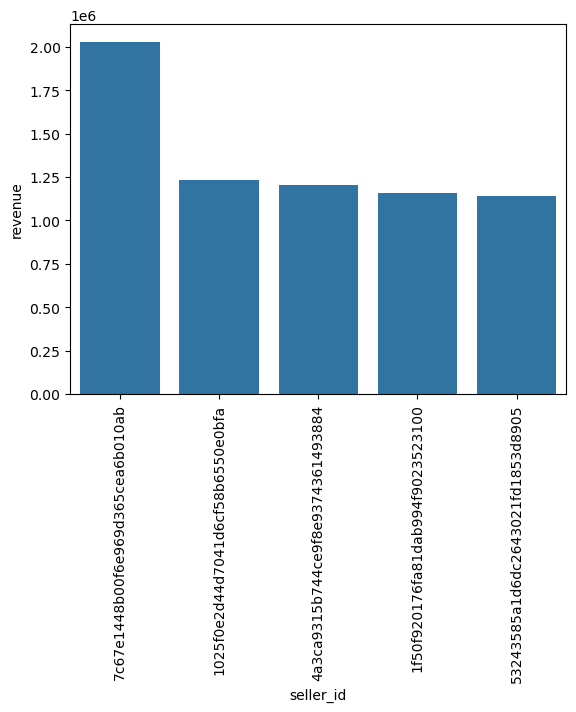

In [24]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
#Calculate the moving average of order values for each customer over their order history.

In [25]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
831083,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831084,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831085,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831086,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


In [ ]:
#Calculate the cumulative sales per month for each year.

In [26]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,2017.92,2.017920e+03
1,2016,10,472723.84,4.747418e+05
2,2016,12,156.96,4.748987e+05
3,2017,1,1107904.32,1.582803e+06
4,2017,2,2335264.08,3.918067e+06
5,2017,3,3598908.80,7.516976e+06
6,2017,4,3342304.24,1.085928e+07
7,2017,5,4743350.56,1.560263e+07
8,2017,6,4090211.04,1.969284e+07
9,2017,7,4739063.36,2.443191e+07


In [ ]:
#Calculate the year-over-year growth rate of total sales.

In [27]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


In [ ]:
#Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [28]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

In [ ]:
#Identify the top 3 customers who spent the most money in each year.

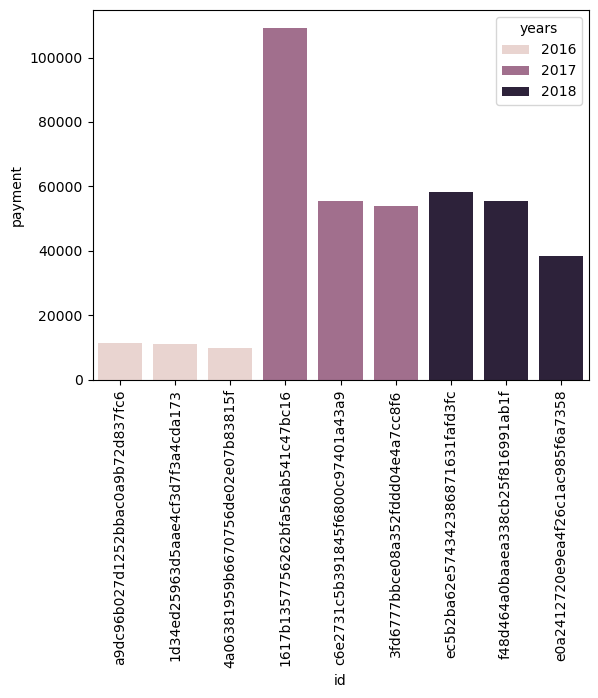

In [29]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()